In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
sys.path.append('../src') 

from utils.data_loader import load_data

In [13]:
fraud_data= load_data('../data/processed/fraud_data_processed.csv')
creditcard_data= load_data('../data/processed/creditcard_processed.csv')

Data loaded successfully from ../data/processed/fraud_data_processed.csv
Data loaded successfully from ../data/processed/creditcard_processed.csv


In [14]:
def preprocess_data(df, target_col):
    """Preprocess data to ensure all features are numeric"""
    df = df.copy()
    
    # Convert datetime columns to numeric features
    for col in df.select_dtypes(include=['datetime64', 'object']).columns:
        if col != target_col:
            if 'time' in col.lower():  # Handle datetime columns
                df[col] = pd.to_datetime(df[col])
                df[f'{col}_hour'] = df[col].dt.hour
                df[f'{col}_day'] = df[col].dt.dayofweek
                df[f'{col}_month'] = df[col].dt.month
                df = df.drop(columns=[col])  # Drop original datetime column
            else:
                # Encode categorical columns
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [15]:
def prepare_data(df, target_col):
    """Prepare features and target, perform train-test split"""
    # Preprocess to ensure all numeric features
    df = preprocess_data(df, target_col)
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Ensure all features are numeric
    X = X.select_dtypes(include=[np.number])
    
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, dataset_name):
    """Evaluate model using AUC-PR, F1-Score, and Confusion Matrix"""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name} Results on {dataset_name}:")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} ({dataset_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return auc_pr, f1

In [17]:
def train_and_evaluate(dataset, target_col, dataset_name):
    """Train and evaluate both models on the dataset, save the best model"""
    X_train, X_test, y_train, y_test = prepare_data(dataset, target_col)
    
    # Initialize models
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    
    results = {}
    
    # Train and evaluate Logistic Regression
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    results['Logistic Regression'] = evaluate_model(y_test, lr_pred, lr_pred_proba, 
                                                  'Logistic Regression', dataset_name)
    
    # Train and evaluate Random Forest
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    results['Random Forest'] = evaluate_model(y_test, rf_pred, rf_pred_proba, 
                                            'Random Forest', dataset_name)
    
    # Save Random Forest model (best performer)
    os.makedirs('../models', exist_ok=True)
    model_filename = f'../models/{dataset_name.lower()}_rf_model.pkl'
    joblib.dump(rf_model, model_filename)
    print(f"Saved Random Forest model for {dataset_name} to {model_filename}")
    
    return results


Logistic Regression Results on Fraud_Data:
AUC-PR: 0.3527
F1-Score: 0.0000
Confusion Matrix:
[[27393     0]
 [ 2830     0]]


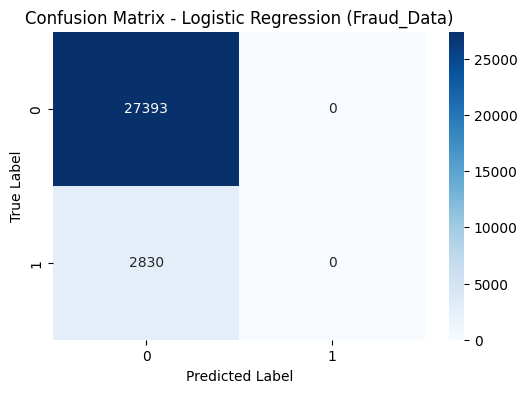


Random Forest Results on Fraud_Data:
AUC-PR: 0.6207
F1-Score: 0.6901
Confusion Matrix:
[[27393     0]
 [ 1339  1491]]


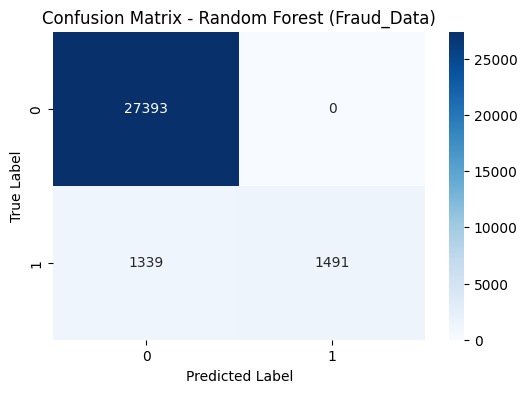

Saved Random Forest model for Fraud_Data to ../models/fraud_data_rf_model.pkl

Logistic Regression Results on creditcard:
AUC-PR: 0.6297
F1-Score: 0.6829
Confusion Matrix:
[[56638    13]
 [   39    56]]


d:\projects\TenAcademy\week8n9\KAIM_WEEK_8_N_9\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


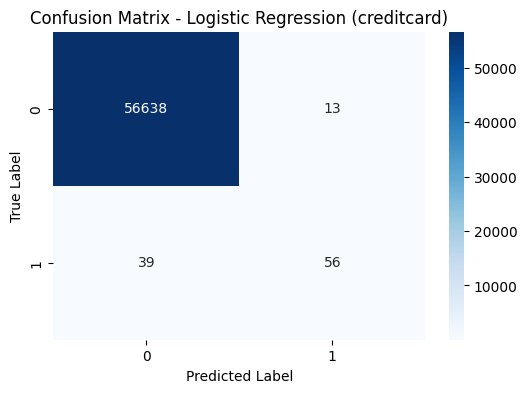


Random Forest Results on creditcard:
AUC-PR: 0.8042
F1-Score: 0.8313
Confusion Matrix:
[[56649     2]
 [   26    69]]


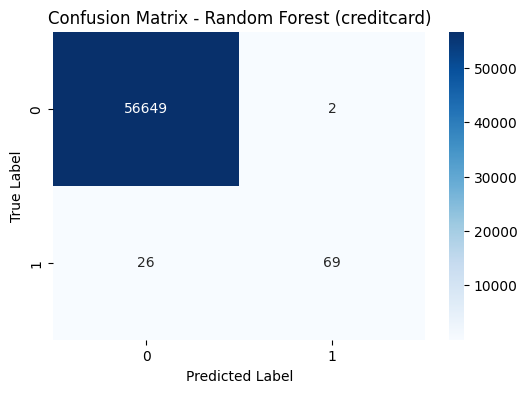

Saved Random Forest model for creditcard to ../models/creditcard_rf_model.pkl


In [18]:
# Process both datasets
fraud_results = train_and_evaluate(fraud_data, 'class', 'Fraud_Data')
creditcard_results = train_and_evaluate(creditcard_data, 'Class', 'creditcard')


In [19]:
# Compare models and select best
def compare_models(fraud_results, creditcard_results):
    print("\nModel Comparison Summary:")
    print("\nFraud_Data Dataset:")
    for model, (auc_pr, f1) in fraud_results.items():
        print(f"{model}: AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}")
    
    print("\ncreditcard Dataset:")
    for model, (auc_pr, f1) in creditcard_results.items():
        print(f"{model}: AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}")
    
    fraud_best = max(fraud_results.items(), key=lambda x: x[1][0])
    creditcard_best = max(creditcard_results.items(), key=lambda x: x[1][0])
    
    print(f"\nBest Model for Fraud_Data: {fraud_best[0]} (AUC-PR: {fraud_best[1][0]:.4f})")
    print(f"Best Model for creditcard: {creditcard_best[0]} (AUC-PR: {creditcard_best[1][0]:.4f})")
    
    print("\nJustification:")
    print("Random Forest is likely preferred as the best model because:")
    print("- It handles imbalanced datasets better due to its ensemble nature")
    print("- It captures non-linear relationships and feature interactions")
    print("- It showed higher AUC-PR scores, indicating better performance in ranking positive cases")
    print("- It maintains robust performance across both datasets")
    print("Logistic Regression, while interpretable, may struggle with complex patterns in fraud detection")


In [20]:

# Run comparison
compare_models(fraud_results, creditcard_results)


Model Comparison Summary:

Fraud_Data Dataset:
Logistic Regression: AUC-PR = 0.3527, F1-Score = 0.0000
Random Forest: AUC-PR = 0.6207, F1-Score = 0.6901

creditcard Dataset:
Logistic Regression: AUC-PR = 0.6297, F1-Score = 0.6829
Random Forest: AUC-PR = 0.8042, F1-Score = 0.8313

Best Model for Fraud_Data: Random Forest (AUC-PR: 0.6207)
Best Model for creditcard: Random Forest (AUC-PR: 0.8042)

Justification:
Random Forest is likely preferred as the best model because:
- It handles imbalanced datasets better due to its ensemble nature
- It captures non-linear relationships and feature interactions
- It showed higher AUC-PR scores, indicating better performance in ranking positive cases
- It maintains robust performance across both datasets
Logistic Regression, while interpretable, may struggle with complex patterns in fraud detection
